# Project Description

For this task I used the **GTSRB** dataset:  
**GTSRB-Training_fixed.zip** from  
<https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/published-archive.html>.

The dataset contains intuitive, easy-to-understand objects and requires far less expert knowledge than medical image classification. Additionaly, its visible-light modality allows the use of pretrained classification backbones such as **Xception**, **MobileNet**, **VGG16** and others.

I selected **Jupyter Notebooks** for this task, as they provide a clear way to present code together with results and explanations.

The code, the training loop is written in **Keras** 

I did not include input-type testing, exception handling or defensive programming. The code is meant to be strictly **academic/experimental**.

---

## Dataset Analysis

The first step was an initial dasaset exploration:

- class histograms were plotted
- example images from various classes were displayed

A visible **class imbalance** is present in the dataset, with classes having between ~150 and ~1500 samples.  
To aggregate classes and filenames, a **pandas DataFrame** was used.

Additionaly, in each class, images originating from the same series are very similar to each other and contain limited variation. In future improvements, it would be beneficial to introduce some form of **stratification based on the series** to ensure greater diversity in the selected data sapmles.

---
## Dataset Partition

 I selected a **test set** consisting of **10 random samples per class**.

From the remaining data:

- **10%** was treated as **labelled data*,
- **90%** as **unlabelled data*.

The labelled subset was further split into:
- **train set** (80%)
- **validation set** (20%

The **test dataset** is balanced. In contrast, the **labelled** and **unlabelled datasets** are not balanced, as they represent the natural distribution of objects in the original dataset.
)

---

## Data Pipeline

A `tf.data.Dataset` pipeline was created to efficiently load and preprocess the images and labels.

For the model backbone, I selected **Xception** for transfer learning and subsequent fine-tuning.  
Although it is relatively heavy, I have used it extensively imyus wor this was the main reason behind this choicece.

On top of Xception, I added:
- a two-layer dense head,
- two dropout layers (to counter overfitting caused by limited and non-uniform data).

Additional augmentation layers simulating real-world image transformations were applied directly inside the training dataset pipeline. I prefer this approach as it creates an **effectively infinite augmented dataset and allows to use **steps_per_epoch** in **model.fit()** to feed greater variety of augmented samples each epoch.*.

---

## Active Learning Loop

The active learning loop works as follows:

1. **Warm-up phase**  
   - Traiy the top dense layers for 1 epoch.  
     This preventthe damage tong pretrained Xception weights and helpto s establish initial gradients.

2. **Fine-tuning phase**  
   - Unlock and train selected middle and top layers of Xception.

3. **Sample acquisition**  
   - After eaop iteration most informative , **500 samples * from the unlabelled dataset are selected.  
   - Selection is based on **entropy**, assuming that more uncertain predictions correspond to higher information gai As well as the  output class distibutions were chaotic, unniform-like n.Whileut active learning:

- training histor) is stord,
- validation andtestng metrics are loggd,
- these metrics are plotted to llustrate performance changes across iteratios,
- confusion matrices are generated for both test and validation sets.

---


In [1]:
from PIL import Image
import os
from pathlib import Path
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import pandas as pd
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

2025-11-16 11:43:49.174949: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-11-16 11:43:49.174986: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-11-16 11:43:49.175004: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-16 11:43:49.181041: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#path to GTSRB database:
GTSRB_PATH  = r'/tf/NEXTBASE/GTSRB/Training/'

## Helper Functions

These functions are used to:

- create image fles,
- display sample i
- building dataframesages,
- plot class histgrams.


In [3]:
def list_files_recursive(path, extension):
    """
    lists files with given extension at path location
    """
    extension = extension.lower()
    return [str(p) for p in Path(path).rglob(f"*{extension}")]


def build_ppm_dataframe(file_list):
    """
    Build a pandas DataFrame containing class label, series number,
    image number, and full filepath from PPM file paths.
    """
    records = []

    for path in file_list:
        norm_path = os.path.normpath(path)

        class_label = norm_path.split(os.sep)[-2]
        filename = os.path.basename(norm_path)  # e.g.: '00000_00000.ppm'
        name_no_ext = filename.replace(".ppm", "")  # '00000_00000'
        series_num, image_num = name_no_ext.split('_')

        records.append({
            "class_label": class_label,
            "series_number": series_num,
            "image_number": image_num,
            "filepath": path
        })

    df = pd.DataFrame(records)
    return df


def show_mosaic(file_list, mosaic_size=(10, 30), image_size=(64, 64)):
    """
    Display a mosaic of images from a list of PPM files.

    """
    n_images = mosaic_size[0] * mosaic_size[1]
    selected_files = file_list[:n_images]  # take only the first n images
    
    # Create an empty mosaic array
    rows, cols = mosaic_size
    img_height, img_width = image_size
    mosaic = np.zeros((rows * img_height, cols * img_width, 3), dtype=np.uint8)
    
    for idx, file in enumerate(selected_files):
        # Open the image, convert to RGB - not necessary here, and resize
        img = Image.open(file).convert('RGB').resize(image_size)
        row = idx // cols
        col = idx % cols
        # Place the image in the mosaic
        mosaic[row*img_height:(row+1)*img_height, col*img_width:(col+1)*img_width] = np.array(img)
    
    plt.figure(figsize=(12, 12))
    plt.imshow(mosaic)
    plt.axis('off')
    plt.show()

def plot_class_histogram_from_df(df, name =""):
    """
    Plot a histogram of sample counts per class from the PPM dataframe,
    and return the counts as a pandas DataFrame.

    """
    counts = df['class_label'].value_counts().sort_index()

    plt.figure(figsize=(12, 6))
    plt.bar(counts.index, counts.values)
    plt.xlabel("Class label")
    plt.ylabel("Number of samples")
    plt.title(f"Histogram of samples per class, {name}")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

    #dataframe version of the histogram
    result_df = pd.DataFrame({
        "class_label": counts.index,
        "count": counts.values
    })

    return result_df

## Dataset Sample Analysis



- List ll `les.
- Visuet of thedata.
- Plot the class hisogram.



number of .ppm files: 26640



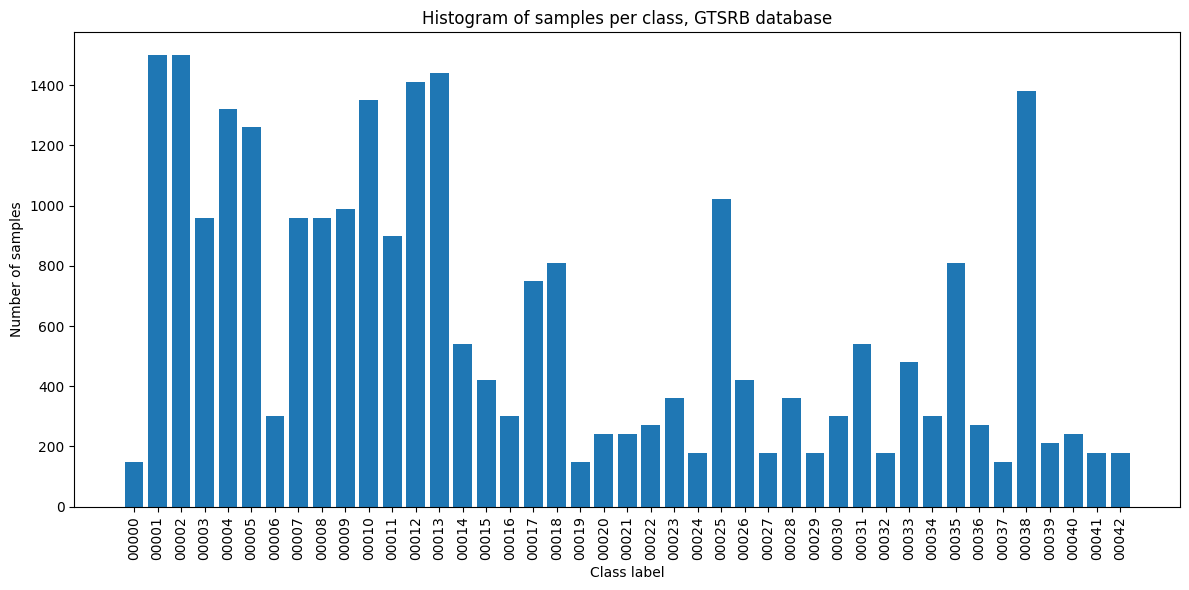

In [4]:
ppm_files = sorted(list_files_recursive(GTSRB_PATH, ".ppm"))
# csv_files = sorted(list_files_recursive(GTSRB_PATH, ".csv"))

print(f'\nnumber of .ppm files: {len(ppm_files)}\n')#,\nnumber of .csv files: {len(csv_files)}\n')

ppm_df = build_ppm_dataframe(ppm_files)
hist_df = plot_class_histogram_from_df(ppm_df, 'GTSRB database')

In [5]:
ppm_df.head(5)

,class_label,series_number,image_number,filepath
0,00000,00000,00000,/tf/NEXTBASE/GTSRB/Training/00000/00000_00000.ppm
1,00000,00000,00001,/tf/NEXTBASE/GTSRB/Training/00000/00000_00001.ppm
2,00000,00000,00002,/tf/NEXTBASE/GTSRB/Training/00000/00000_00002.ppm
3,00000,00000,00003,/tf/NEXTBASE/GTSRB/Training/00000/00000_00003.ppm
4,00000,00000,00004,/tf/NEXTBASE/GTSRB/Training/00000/00000_00004.ppm


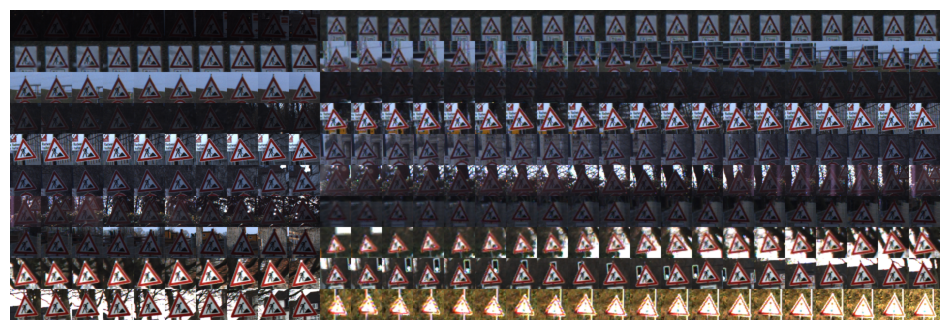

In [6]:
show_mosaic(ppm_files[20000:])

## Database Split

The dataset was divided into the following subsets:

- **Train set**  
- **Validation set**  
- **Unlabelled set**  
- **Tes set**


In [7]:
#test dataset of N_samples_per_class random samples of each class, seed is fixed to obtain tha same samples each run of the notebook
dataset_partition_seed = 0
N_samples_per_class = 10

test_df = ppm_df.groupby("class_label").sample(n=N_samples_per_class, replace=False, random_state=dataset_partition_seed)

#remove test samples from ppm_df dataframe
ppm_df = ppm_df.drop(test_df.index).reset_index(drop=True)
test_df = test_df.reset_index(drop=True)


In [8]:
#split the rest of the dataset into the labelled set 10% of each class samples and the unlabeled dataset

partition_ratio = 0.1 #10% labelled DS, 90% unlabelled DS
sampled_list = []

for class_label, group in ppm_df.groupby("class_label"):
    
    n_samples = max(1, int(len(group) * partition_ratio))
    
    sampled = group.sample(n=n_samples, replace=False, random_state=dataset_partition_seed)
    sampled_list.append(sampled)

train_df = pd.concat(sampled_list, ignore_index=False)
unlabelled_df = ppm_df.drop(train_df.index).reset_index(drop=True)
train_df = train_df.reset_index(drop=True)

In [9]:
#split the the labelled dataset into the train/ validation datasets

partition_ratio = 0.2 #train / validation = 80%/20% ratio
sampled_list = []

for class_label, group in train_df.groupby("class_label"):
    
    n_samples = max(1, int(len(group) * partition_ratio))
    
    sampled = group.sample(n=n_samples, replace=False, random_state=dataset_partition_seed)
    sampled_list.append(sampled)

validation_df = pd.concat(sampled_list, ignore_index=False)
train_df = train_df.drop(validation_df.index).reset_index(drop=True)
validation_df = validation_df.reset_index(drop=True)

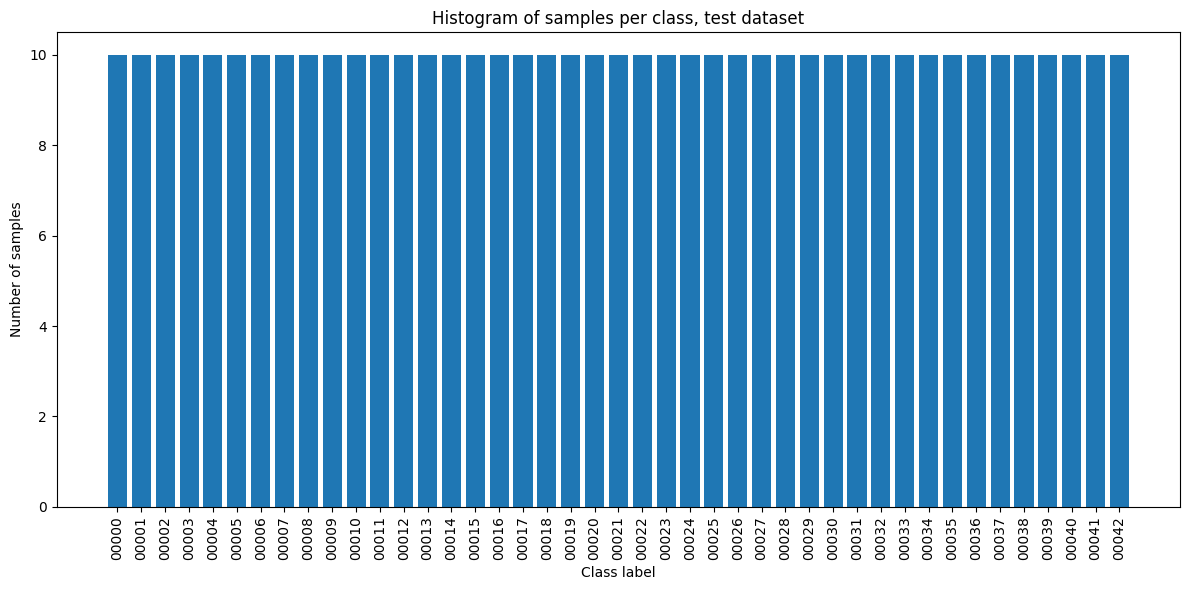

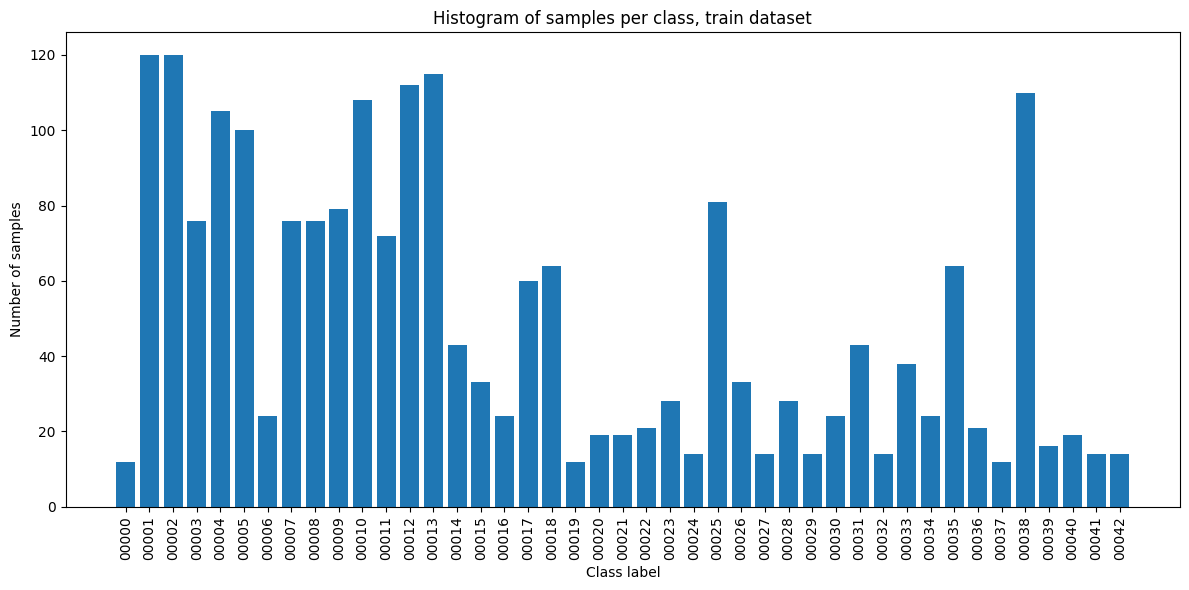

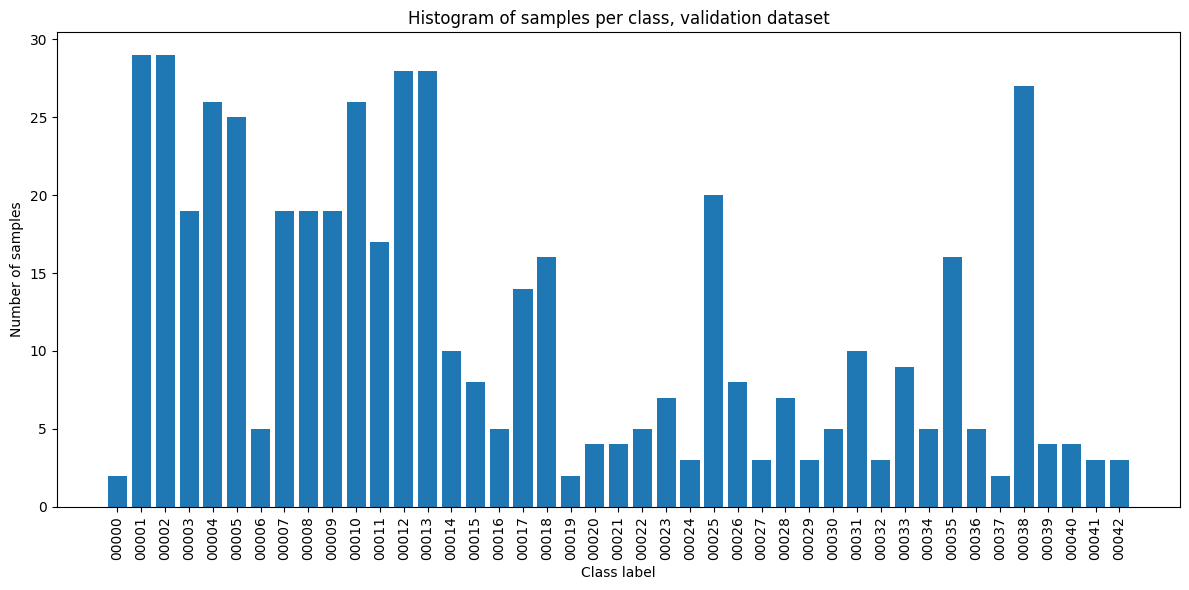

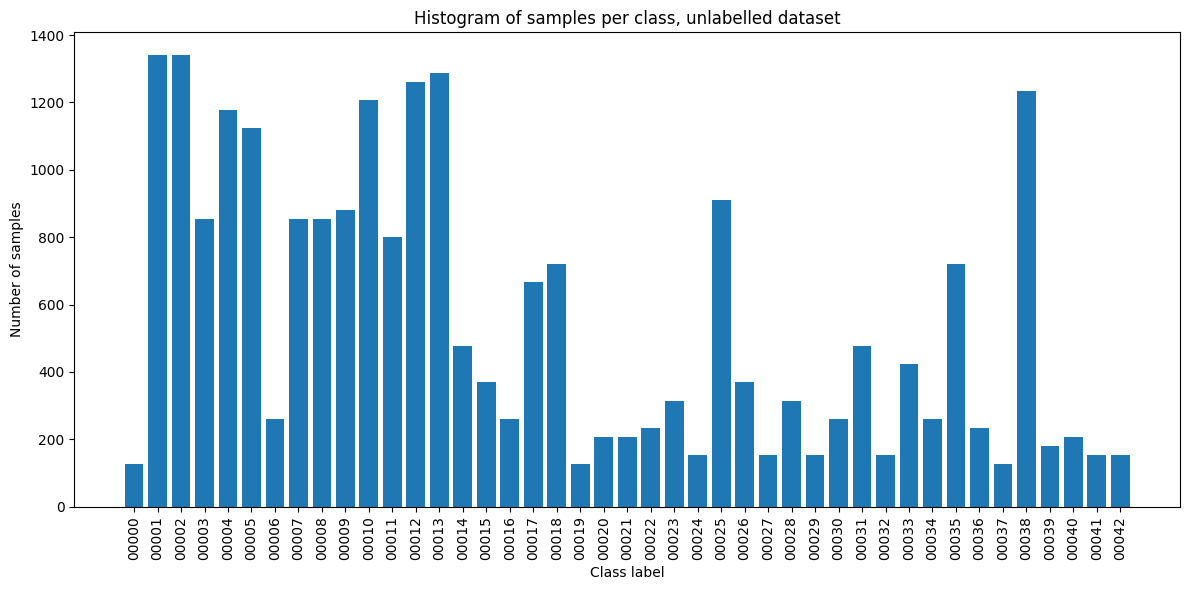

In [10]:
#show histogram of test set
test_df_hist = plot_class_histogram_from_df(test_df, 'test dataset') 
train_df_hist = plot_class_histogram_from_df(train_df, 'train dataset') 
validation_df_hist = plot_class_histogram_from_df(validation_df, 'validation dataset') 
unlabelled_df_hist = plot_class_histogram_from_df(unlabelled_df, 'unlabelled dataset') 

## TF Dataset Helper Functions

This section contains helper functions for creating and visualizing TensorFlow datasets from the image files.

The functions include:

- **Loading images from a file list** into a `tf.data.Dataset`.
- **Resizing images** to the input size required by the pretrained Xception backbone (`299x299`).
- **Normalizing image pixel values** to the range `[0, 1]`.
- **Visualizing batches** of images with their labels for sanity checks.

In [11]:
#TF Dataset helper functions:
#loading image from file list into tf.data.Dataset
#resizing to the input size of pretrained Xception
#image range normalization to 0-1

backbone_image_size = 299 #224 299

#opens ppm v6 image file, returns rescaled and resized image
def load_ppm_image_pil(path, label):
    image = Image.open(path.numpy())        
    image = image.resize((backbone_image_size, backbone_image_size))
    image = np.array(image) / 255.0        
    return image.astype(np.float32), label

# TensorFlow wrapper of load_ppm_image_pil
#wraps the image loadnig function to be used in Dataset mapping
def tf_load_ppm(path, label):
    
    image, label = tf.py_function(func=load_ppm_image_pil,
                                  inp=[path, label],
                                  Tout=(tf.float32, tf.int64))
    image.set_shape([backbone_image_size, backbone_image_size, 3]) 
    label.set_shape([]) 
    return image, label

#creates tf.data.Dataset from given dataframe
def get_dataset(df):
    
    file_paths = df['filepath'].values
    labels = df['class_label'].values.astype(int)
    
    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    dataset = dataset.map(tf_load_ppm)

    return dataset

 #shows images and labels from dataset for sanity check
def show_dataset(dataset):  
    
    for images, labels in dataset.shuffle(1000).batch(32).take(1):
        print("Batch images shape:", images.shape)  # (batch_size, 128, 128, 3)
        print("Batch labels:", labels.numpy())
    
        plt.figure(figsize=(10, 5))
        for i in range(min(9, images.shape[0])):  
            plt.subplot(3, 3, i+1)
            plt.imshow(images[i].numpy())
            plt.title(f"Label: {labels[i].numpy()}")
            plt.axis('off')
        plt.show()
        break

In [12]:
#create tf.data.Datasets from dataframes
train_dataset = get_dataset(train_df)
validation_dataset = get_dataset(validation_df)
test_dataset = get_dataset(test_df)
unlabelled_dataset = get_dataset(unlabelled_df)

2025-11-16 11:43:52.935962: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-11-16 11:43:52.958018: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-11-16 11:43:52.958216: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

## Image Augmentation and Model Definition

This section defines **image augmentatins** and the **modre itself**.  

### Image Augmentation

Basic data augmentation is applied to the training set to simulate real-life variations in image acquisition:

- **Random rotation**
- **Random zoom**
- **Random translation**

> Note: Additional augmentation laye**rs, such as intensity** adj**ustments or motion blu**r simulation, could be added in future iterations if more time is available. improve enhance the model's ro to  iverse real-world conditions.


In [13]:
#baisic data augmentation transformations for training set
data_augmentation = tf.keras.Sequential([      
    tf.keras.layers.RandomRotation(0.1),               
    tf.keras.layers.RandomZoom(0.1),                   
    tf.keras.layers.RandomTranslation(0.1, 0.1)        
])

#model definition, feature xtractor is Google Xception with frozen layers 
inputs = tf.keras.layers.Input(shape=(backbone_image_size, backbone_image_size, 3))
x = tf.keras.applications.xception.preprocess_input(inputs)
base_model = tf.keras.applications.Xception(include_top=False, weights='imagenet', input_tensor=x)
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x = tf.keras.layers.Dropout(0.3)(x)  #lots of features, little data so dropout here
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(43, activation='softmax')(x)
model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

base_model.trainable = False

## Active Learning Loop

This section implements the **active learning loop**, where model is iteratively fine-tuned on the moschaoticiprediction results s from the unlabelled dataset.

### Loop Setup

- **Metrics storage**: loss, accuracy, and training histories are preserved for each run.
- **Parameters**:
  - `N_uned = 500` → number of most uncertain samples added to the training set per iteration.
  - `N_acruns = 10` → number of active leaning iterations.

### Iterative Training Procedure

For each active learning run:

1. **Class weights computation**  
   Due to significant class imbalance in the training dataset, class weights are recalculated in each iteration.

2. **Data augmentation**  
   Applied directly to the training dataset using `tf.data.Dataset` pipeline with `.repeat()` to create an effectively infinite augmented dataset.

3. **Warm-up training (first iteration only)**  
   - Train only theop denslayers fo **1 epoch** to establish small gradients and avoid disturbing pretred Xception weights.  
   - After warm-up, selected top and middle layers of theception ckbone are **unlcked** for fine-tuning.

4. **Fine-tuning**  
   - Model is compiled wi
   - Learning rate reduction reduces the learning rate if no improvement in **val_loss** is observed before early stopping
 learning rate (`1e-5`).  
   - Early stopping callback monitors validation loss and restores the best weights.  
   - Model is trained on the augmented dataet, and the history is saved.

5. **Metrics evaluation**  
   - Test and validation datasets arevaluated afte- Metrics (`accuracy` and `loss`) ae stored for later visualization.

6. **Active sample selection**  
   - Predictions one unlabled datet are computed.  
   - **Entropy** of the predid soft probabilities is calculated.  
   - Top `N_unlabelled` samples with highesttropy (most uncertain) are selected.  

7. **Dataset update**  
   - Selected samples are added to the training dataset and removed from the unlabelled dataset.  
   - New `tf.data.Dataset` pipelines are created for the  iteration to monitor performance changes.



In [ ]:
#preserve loss,accuracy metrics and history wile active training
test_accuracy = []
test_loss = []
validation_accuracy = []
validation_loss = []
histories = []

N_unlabelled = 500  #number of the most chaotic samples that will be transfered to training set each run
N_active_runs = 10 #number of active training loop runs

for i in range(N_active_runs):

    print(f'Training run no. {i+1}/{N_active_runs}')
    
    #class weights computation durrin each run as there is a significant inbalance in train dataset
    y_train = train_df['class_label'].values.astype(int)
    class_weights_values = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
    class_weights = {i: w for i, w in enumerate(class_weights_values)}

    #application of data augmentation directly to train_dataset,
    #infinite set (repeat) because I use data augmentation
    train_dataset = train_dataset.shuffle(1000).repeat().map(lambda x, y: (data_augmentation(x, training=True), y),
                                  num_parallel_calls=tf.data.AUTOTUNE)
    
    #first training run of only top dense layers to establish small gradient and small updates for fine tuning
    #warmup performed for the first initial epoch
    if i==0:
        
        optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
        model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
        history1 = model.fit(
            train_dataset.batch(8).prefetch(tf.data.AUTOTUNE),
            validation_data=validation_dataset.batch(32).prefetch(tf.data.AUTOTUNE),
            epochs=1,
            class_weight=class_weights,
            steps_per_epoch=1000
        )
        histories.append(history1)
    
        # top and middle Xception layers unlocked for training
        for layer in base_model.layers:
            if layer.name.startswith(('block8','block9','block10','block11','block12','block13','block14')):
                layer.trainable = True
    
    #compiling model for fine tuning runs with smaller LR:  
    optimizer_finetune = tf.keras.optimizers.Adam(learning_rate=3e-5)
    model.compile(optimizer=optimizer_finetune, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    
    #early stopping callback monitoring validation loss
    EarlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=5)
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-6)

    
    #Fine-tuning
    history = model.fit(
        train_dataset.batch(8).prefetch(tf.data.AUTOTUNE),
        validation_data=validation_dataset.batch(32).prefetch(tf.data.AUTOTUNE),
        epochs=15,
        class_weight=class_weights,
        steps_per_epoch=1000,
        callbacks=[EarlyStopping, reduce_lr]
    )
    histories.append(history)

    #save metrics and loss
    loss_test, accuracy_test = model.evaluate(test_dataset.batch(32))
    loss_val, accuracy_val = model.evaluate(validation_dataset.batch(32))
    test_accuracy.append(accuracy_test)
    validation_accuracy.append(accuracy_val)
    test_loss.append(loss_test)
    validation_loss.append(loss_val)

    #calculating entropy since the soft probabilities after training have almost uniform distribution
    results = model.predict(unlabelled_dataset.batch(32))
    entropy = [-np.sum(p * np.log(p + 1e-10)) for p in results]
    samples_with_entropy = list(zip(results, entropy, [i for i in range(len(results))]))
    samples_sorted = sorted(samples_with_entropy, key=lambda x: x[1], reverse=True)[:N_unlabelled]
    top_indices = [el[-1] for el in samples_sorted]
    
    #add samples to train df, remove from unlabelled df
    top_samples_df = unlabelled_df.iloc[top_indices] 
    unlabelled_df = unlabelled_df.drop(unlabelled_df.index[top_indices])
    train_df = pd.concat([train_df, top_samples_df], ignore_index=True)

    #create new train and unlabelled datasets
    train_dataset = get_dataset(train_df)
    unlabelled_dataset = get_dataset(unlabelled_df)

    
    # # loss / accuracy plots
    # plt.figure(figsize=(10,5))
    
    # # Loss
    # plt.plot(history.history['loss'], label='train_loss')
    # plt.plot(history.history['val_loss'], label='val_loss')
    
    # plt.title('Training and Validation Loss')
    # plt.xlabel('Epoch')
    # plt.ylabel('Value')
    # plt.legend()
    # plt.grid(True)
    # plt.show()
    
    # # Accuracy
    # plt.figure(figsize=(10,5))
    # plt.plot(history.history['accuracy'], label='train_acc')
    # plt.plot(history.history['val_accuracy'], label='val_acc')
    
    # plt.title('Training and Validation Accuracy')
    # plt.xlabel('Epoch')
    # plt.ylabel('Value')
    # plt.legend()
    # plt.grid(True)
    # plt.show()


Training run no. 1/10


2025-11-16 11:43:57.979943: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600
2025-11-16 11:43:59.251362: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0xd8cd9e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-16 11:43:59.251391: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2025-11-16 11:43:59.257771: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-16 11:43:59.343219: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1000/1000 [==============================] - 48s 43ms/step - loss: 3.7424 - accuracy: 0.0306 - val_loss: 3.7493 - val_accuracy: 0.0395
Epoch 1/25
1000/1000 [==============================] - 71s 61ms/step - loss: 3.6188 - accuracy: 0.0641 - val_loss: 3.3342 - val_accuracy: 0.0870 - lr: 3.0000e-05
Epoch 2/25
1000/1000 [==============================] - 61s 61ms/step - loss: 3.2184 - accuracy: 0.1396 - val_loss: 2.9844 - val_accuracy: 0.1700 - lr: 3.0000e-05
Epoch 3/25
1000/1000 [==============================] - 61s 61ms/step - loss: 2.8475 - accuracy: 0.2027 - val_loss: 2.9415 - val_accuracy: 0.1601 - lr: 3.0000e-05
Epoch 4/25
1000/1000 [==============================] - 61s 61ms/step - loss: 2.5757 - accuracy: 0.2530 - val_loss: 2.5863 - val_accuracy: 0.2372 - lr: 3.0000e-05
Epoch 5/25
1000/1000 [==============================] - 61s 61ms/step - loss: 2.2645 - accuracy: 0.3316 - val_loss: 1.7792 - val_accuracy: 0.4032 - lr: 3.0000e-05
Epoch 6/25
1000/1000 [============================

## Plotting Metrics and Loss


- **Training vs Validation Accuracy**  
  Plots the accuracy per epoch across all active learning iterations for both the training and validation sets.

- **Training vs Validation Loss**  
  Plots the loss per epoch across all active learning iterations for both the training and validation sets.

- **Test vs Validation Loss**  
  Compares the loss on the test set and validation set across all iterations.

- **Test vs Validation Accuracy**  
  Compares the accuracy on the test set and validation set across alactive learning.


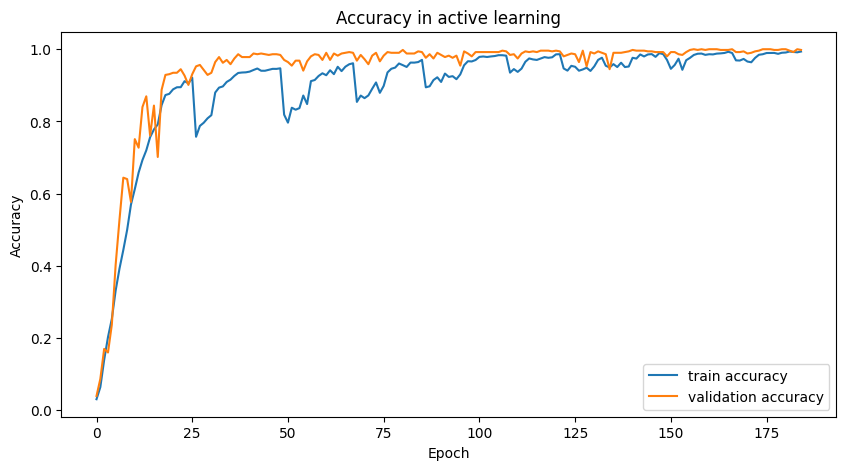

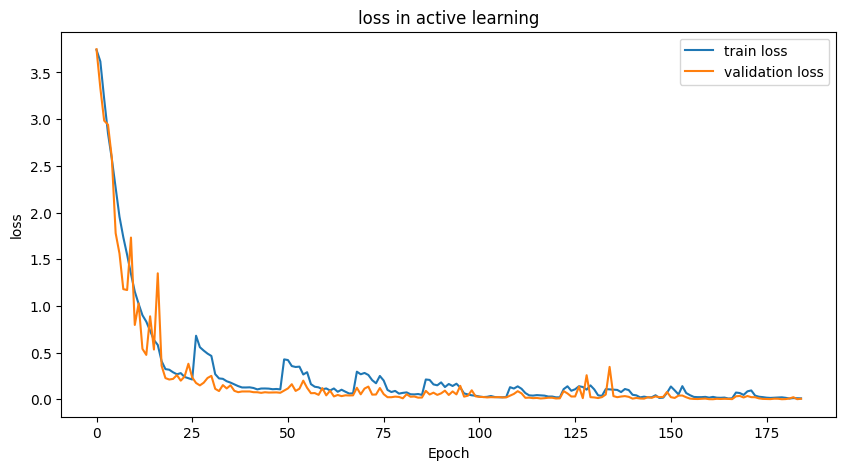

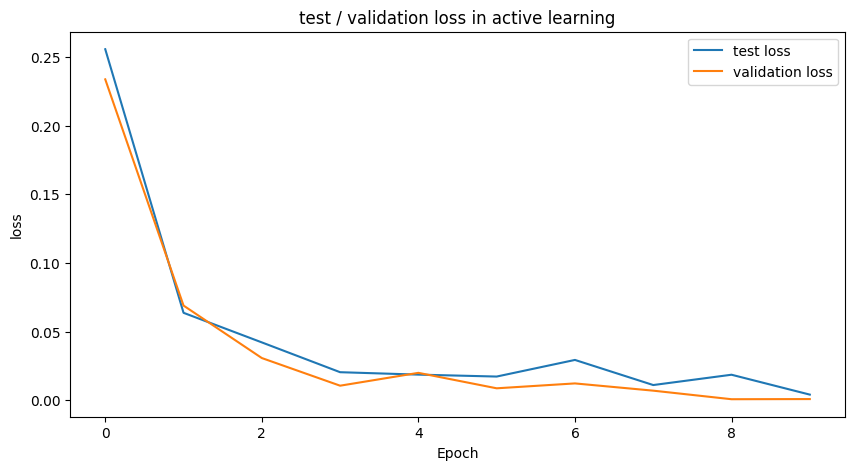

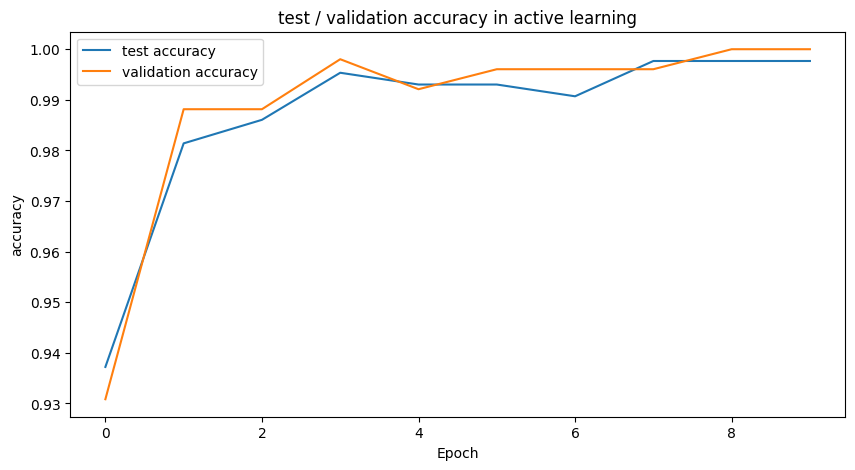

In [18]:
#plot metrics and losses for the whole active learnign process
train_acc = []
train_loss = []
val_acc = []
val_loss = []

for h in histories:
    train_acc.extend(h.history["accuracy"])
    train_loss.extend(h.history["loss"])
    val_acc.extend(h.history["val_accuracy"])
    val_loss.extend(h.history["val_loss"])

plt.figure(figsize=(10,5))
plt.plot(train_acc, label="train accuracy")
plt.plot(val_acc, label="validation accuracy")
plt.title("Accuracy in active learning")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(train_loss, label="train loss")
plt.plot(val_loss, label="validation loss")
plt.title("loss in active learning")
plt.xlabel("Epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(test_loss, label="test loss")
plt.plot(validation_loss, label="validation loss")
plt.title("test / validation loss in active learning")
plt.xlabel("Epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(test_accuracy, label="test accuracy")
plt.plot(validation_accuracy, label="validation accuracy")
plt.title("test / validation accuracy in active learning")
plt.xlabel("Epoch")
plt.ylabel("accuracy")
plt.legend()
plt.show()

## Confusion MatricesC**confusion matris** are plotted for both the **test** and **validation** dsetsnce.


14/14 [==============================] - 2s 129ms/step


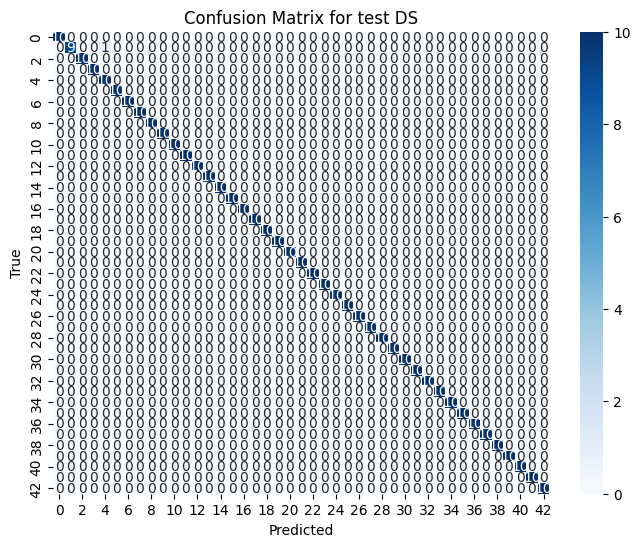

In [19]:
#test set evaluation
results = model.predict(test_dataset.batch(32))

y_pred = np.argmax(results, axis=1)
y_true = np.array([label.numpy() for _, label in test_dataset])
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for test DS")
plt.show()

16/16 [==============================] - 2s 133ms/step


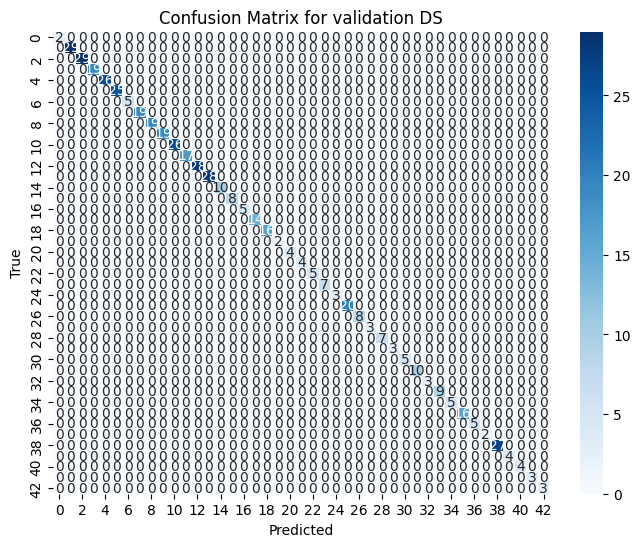

In [20]:
#validation set evaluation
results = model.predict(validation_dataset.batch(32))

y_pred = np.argmax(results, axis=1)
y_true = np.array([label.numpy() for _, label in validation_dataset])
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for validation DS")
plt.show()

## Discussion and suggested improvements

If more timwasre available, the following improvements and experiments could be considered:

### aset
- **Series-based stratification**: Stratify based on image series, as images within the same series are very similar.  
- **Evaluation on official test set**: Test the model on the official competition test set to verify generalization.  
- **Pipeline optimization**: Use buffering,  to speed up the trainingements.  
- **Extended data augmentation**: Simulate motion blur,image  varied y changesnsities, and contrasts to improve robustness.  

### Algorithm
- **Backbone alternatives**: Experiment with MobileNetV2 instead  - its loighter and faster
- **Transformer Backbones**: Given more time, I would try the **Swin Transformer**, as its hierarchical feature representation performs very well in computer vision tasks. So far, I have used it only as a feature extractor for classification with traditional machine learning models (such as SVM and XGBoost). Because of that, I am not yet fully familiar with its transfer learning and fine-tuning procedures.Xception.  
- **Progressive layer unfreezing**: Gradually unlock backbone layers as new training da
- **Early stopping** for active learning loop: implement active loop termination if adding more data does not bring significant improvements, similar to model.fit() EarlyStopping Callbacka of images.  

### Training Loop
- **Experiment tracking**: Log results with TensorBoard for better visualization of metrics.  
- **Learning rate scheduling**: Implement dynamic LR scheduling during training.  
- **HyperparameteNumber of epochs, t optimization**: Tune learning rate, number of unlocked Xception layers, augmentation parameters, and dense layer configuration (neuron, batch size, number of Active Learning runs, number of number Active Learning sampless, regularization). / Testing  

### Validation
- **K-fold cross-validation**: Implement k-fold to obtain more objective performance estimates (one full training takes ~2–3 hours, so 10-fold could be feasible).  
- **Multiple training runs**: Repeat experiments to assess stability and variability of results.  
- **Deeper error analysis**: Review confusion matrices on the validation set to identify systema Confusion matrices suggest that distinguishing between different speed limit signs is less accuratec misclassifications.  

### Code Arrangement
- **Code quality**: Add comprehensive comments and documentation.  
- **Modular code design**: R - for easier rearanging training strategies, validation, etc.native training strategies.
evaluation metrics.
